In [1]:
from tqdm import tqdm_notebook as tqdm

# Bose-Einstein condensation

## Partition function for N bosons

For indistiguishable, non-interacting bosons, weights in path integrals need identical positions, but can have **permutations**, so that partition function reads:

$$Z = \frac{1}{N!}\int dx_0...dx_{N-1} \sum_P \rho(x_0, ..., x_{N-1}; x_{P(0)}, ..., x_{P(N-1)})$$

In the example below, the permutation is written as:
$ P = \bigl(\begin{matrix}
    0 & 3 & 1 & 2 \\
    0 & 1 & 2 & 3
  \end{matrix}\bigr)$

![perm](figs/bosons_perm.png)

The action of the cycle $Z_{(1)(243)}$ is: 

$$Z_{(1)(243)} = \int dx_1\rho(x_1,x_1, \beta)\int dx_2\int dx_3\int dx_4 \rho(x_2,x_4, \beta)\rho(x_4,x_3,\beta)\rho(x_3,x_2, \beta)$$

using convolution: $$Z_{(1)(243)} = \int dx_1\rho(x_1,x_1, \beta)\int dx_2\rho(x_2,x_2, 3\beta) = z(\beta)z(3\beta)$$

where $z(\beta) = \int dx\rho(x,x, \beta)$ is the single-particle partition function

Here $Z_{(1)(243)}$ is a product of a single particle partition functions : one is at temperature $1/\beta$, the other is at $1/3\beta$.

### Canonical partition function
In 1D, $z(\beta) = \sum_{E_x=0}^{\infty}e^{-\beta E_x}=\frac{1}{1-e^{-\beta}}$, leading to $z(\beta) = \bigl(\frac{1}{1-e^{-\beta}}\bigr)^3$ in 3D

Setting $z_k = z(k\beta)$, the partition function for N bosons can be defined using recursion:
$$Z_N= \frac{1}{N}\sum_{k=1}^{N}z_kZ_{N-k}, \space Z_0=1$$

In [4]:
import math, pylab

def z_k(k, beta):
    return 1.0 / (1.0 - math.exp(- k * beta)) ** 3

def canonic_recursion(N, beta):
    Z = [1.0]
    for M in range(1, N + 1):
        Z.append(sum(Z[k] * z_k(M - k, beta) \
                     for k in range(M)) / M)
    return Z

def plot_canonic_recursion():
    N = 128
    for T_star in [0.1, 0.5, 0.5,0.7,0.8,1]:
        beta = 1.0 / N ** (1.0 / 3.0) / T_star
        Z = canonic_recursion(N, beta)
        pi_k = [(z_k(k, beta) * Z[N - k] / Z[-1]) / float(N) for k in range(1, N + 1)]

        # graphics output
        pylab.plot(range(1, N + 1), pi_k, '-', lw=1.5, label='$T^*=%s$' % T_star)
        pylab.ylim(0.0, 0.02)
        pylab.xlabel('cycle length $k$', fontsize=16)
        pylab.ylabel('cycle probability $\pi_k$', fontsize=16)
        #pylab.title('Cycle length distribution ($N=%i$, $T^*=%s$)' % (N, T_star), fontsize=16)
    pylab.legend()


#### For low temperatures, distribution of cycle lengths extend to high values (~N), for high temperatures, there are almost no permutations.

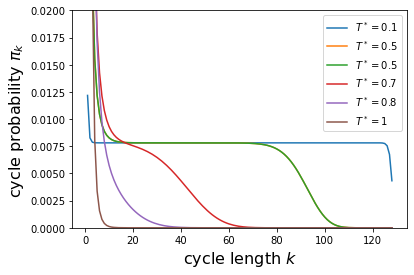

In [5]:
plot_canonic_recursion()

## Markov chain Monte Carlo for bosons

Sample probability distribution for N ideal bosons using Markov Chain Monte Carlo. Attempt moves in position and in permutations.

Start with initial paths with no permutations

![perm](figs/boson_init.png)

### Particle move

Sample a random marticle and find its permutation cycle:

![perm](figs/boson_perm1.png)

Sample a new Lévy path of same length as cycle and fold it back

![perm](figs/boson_perm2.png)

There are no rejections since we use Lévy sampling

### Permutation move

Pick two random particle and attempt a permutation

![perm](figs/boson_perm3.png)

Accept the permutation move using Metropolis acceptance rule.

For example, for 

$$\bigl(\begin{matrix}
    0 & 3 & 1 & 2 \\
    0 & 1 & 2 & 3
  \end{matrix}\bigr) \rightarrow \bigl(\begin{matrix}
    0 & 1 & 3 & 2 \\
    0 & 1 & 2 & 3
  \end{matrix}\bigr)$$

Metropolis rule is: 

$$\mathbb{P}_{\text{accept}}=\min{(1, \frac{\pi(a)}{\pi(b)})} = \frac{\rho^{harm}(x_{1}, x_{3}, \beta)\rho^{harm}(x_{1}, x_{1}, \beta)}{\rho^{harm}(x_{2}, x_{3}, \beta)\rho^{harm}(x_{2}, x_{1}, \beta)} $$

where $\rho^{harm}$ is given by exact analytical solution for the harmonic oscillator.

In [6]:
import random, math, pylab, mpl_toolkits.mplot3d

In [7]:
def levy_harmonic_path(k, beta, omega):
    '''
    Lévy path in a harmonic potential
    k is the length of the cycle (inv temperature = k*beta)
    '''
    sigma = [1.0 / math.sqrt(2.0 * omega[d] *
             math.tanh(0.5 * k * beta * omega[d])) for d in range(3)]
    # initial condition sampled from pi(x) exact solution distribution for a Harmonic potential
    xk = tuple([random.gauss(0.0, sigma[d]) for d in range(3)])
    x = [xk]
    # from initial condition, calculate intermediary Lévy paths
    for j in range(1, k):
        Upsilon_1 = [1.0 / math.tanh(beta * omega[d]) +
              1.0 / math.tanh((k - j) * beta * omega[d]) for d in range(3)]
        Upsilon_2 = [x[j - 1][d] / math.sinh(beta * omega[d]) + \
               xk[d] / math.sinh((k - j) * beta * omega[d]) for d in range(3)]
        x_mean = [Upsilon_2[d] / Upsilon_1[d] for d in range(3)]
        sigma = [1.0 / math.sqrt(Upsilon_1[d] * omega[d]) for d in range(3)]
        # using mean and sigma of Lévy path gaussian, sample 3 coordinates x,y and z
        dummy = [random.gauss(x_mean[d], sigma[d]) for d in range(3)]
        x.append(tuple(dummy))
    return x

def rho_harm(x, xp, beta, omega):
    '''
    Exact solution for the off diagonal harmonic density matrix in a 3D harmonic potential,
    x and xp are vectors
    '''
    Upsilon_1 = sum(omega[d] * (x[d] + xp[d]) ** 2 / 4.0 *
                     math.tanh(beta * omega[d] / 2.0) for d in range(3))
    Upsilon_2 = sum(omega[d] * (x[d] - xp[d]) ** 2 / 4.0 /
                     math.tanh(beta * omega[d] / 2.0) for d in range(3))
    return math.exp(- Upsilon_1 - Upsilon_2)


In [8]:
def markov_chain_MC(T_star = 0.9, N=128, nsteps=100000, omega_x=1.0, omega_y=1.0, omega_z=1.0): 
    '''
    Sample positions of N bosons in a 3D harmonic potential using Markov chain Monte Carlo
    '''

    # oscillator strength of potential
    omega = [omega_x, omega_y, omega_z]

    omega_harm = 1.0
    for d in range(3):
        omega_harm *= omega[d] ** (1.0 / 3.0)
    
    T = T_star * omega_harm * N ** (1.0 / 3.0)

    beta = 1.0 / (T_star * N ** (1.0 / 3.0))

    # keys are positions x, y and z
    # values of dictionary = positions of permutation partners
    positions = {}
    cycle_lengths = []
    
    x_all = []
    min_permutations = 10
    pos_long_cycle = [] # positions of bosons on long cycles (more than min_permutations)

    # *** initialization ***
    # Generate N initial paths 
    for j in range(N):
        # initial paths : all are xk to xk (no permutations)
        a = levy_harmonic_path(1, beta, omega)
        positions[a[0]] = a[0]

    for step in tqdm(range(nsteps)):

        # *** particle move ***

        # sample a random particle
        boson_a = random.choice(list(positions.keys())) # list(positions.keys()) ok in python >=3.7 order of keys is maintained
        x_all.append(boson_a[0])

        # compute permutation cycle the particle is on
        perm_cycle = []
        while True:
            perm_cycle.append(boson_a)
            # boson_b = value associated with key boson_a = position of permutation partner
            boson_b = positions.pop(boson_a) # positions dict lost the (boson_a,boson_b) item
            if boson_b == perm_cycle[0]: break
            else: boson_a = boson_b  # will be appended to perm_cycle at next while iteration => updates k
        # length of perm_cycle was updated during while loop
        k = len(perm_cycle)
        if k >= min_permutations:
            pos_long_cycle.append(boson_a[0])

        # using length of cycle k, sample a new harmonic Lévy path for the entire cycle
        perm_cycle = levy_harmonic_path(k, beta, omega) # This path goes from x0(beta=0) to xN(beta=kbeta), it is unfolded
        # Add the new Lévy path to positions dictionary:
        # we need to fold it back to a cycle between 0 and beta
        # 1- link last elem of Lévy path to first element
        positions[perm_cycle[-1]] = perm_cycle[0]
        # 2 - link intermediary stages of the cycle
        for j in range(len(perm_cycle) - 1):
            positions[perm_cycle[j]] = perm_cycle[j + 1] # values of dictionary = position of permutation partners
        # positions now contains path with no permutations and the new cycle from folded Lévy path

        # *** permutation move ***

        # pick 2 random particles
        a_1 = random.choice(list(positions.keys()))
        b_1 = positions.pop(a_1)
        a_2 = random.choice(list(positions.keys()))
        b_2 = positions.pop(a_2)
        weight_new = rho_harm(a_1, b_2, beta, omega) * rho_harm(a_2, b_1, beta, omega)
        weight_old = rho_harm(a_1, b_1, beta, omega) * rho_harm(a_2, b_2, beta, omega)
        # attempt an exchange using Metropolis
        if random.uniform(0.0, 1.0) < weight_new / weight_old:
            positions[a_1] = b_2
            positions[a_2] = b_1
            cycle_lengths.append(k)
        else:
            positions[a_1] = b_1
            positions[a_2] = b_2
            
    return positions, cycle_lengths, pos_long_cycle, x_all


In [12]:
def plot_distributions(cycle_lengths, pos_long_cycle, x_all, N=128, T_star=0.5, nsteps=500000):

    # canonic recursion
    beta = 1.0 / N ** (1.0 / 3.0) / T_star
    Z = canonic_recursion(N, beta)
    pi_k = [(z_k(k, beta) * Z[N - k] / Z[-1]) / float(N) for k in range(1, N + 1)]

    # ground state
    list_x = [0.1 * a for a in range (-50, 51)]
    list_y = [math.exp(-x**2)/math.sqrt(math.pi) for x in list_x]

    fig, axs = pylab.subplots(1,2, figsize=(15, 6)) 
    axs[0].hist(cycle_lengths, bins=100, density=True, histtype='step', label='Markov chain MC')
    axs[0].plot(range(1, N + 1), pi_k, '-', lw=2.5, label='canonic recursion $T^*=%s$' % T_star)
    axs[0].set_ylim(0.0, 0.02)
    axs[0].set_xlabel('cycle length $k$', fontsize=12)
    axs[0].set_ylabel('cycle probability $\pi_k$', fontsize=12)
    axs[0].set_title('Cycle length distribution ($N=%i$, $T^*=%s$)' % (N, T_star), fontsize=12)
    axs[0].legend()


    axs[1].hist(x_all, bins=100, density=True, histtype='step',label='all bosons')
    axs[1].hist(pos_long_cycle, bins=100, density=True, histtype='step',label='bosons (more than 10 permutations)')
    axs[1].plot(list_x, list_y,label='ground state $e^{-x^2/2}/\sqrt{\pi}$')
    axs[1].set_xlim(-5.0, 5.0)
    axs[1].set_ylim(0, 0.8)
    axs[1].set_xlabel('position', fontsize=12)
    axs[1].set_ylabel('proba density $\pi(x)$', fontsize=12)
    axs[1].set_title('proba density $\pi(x)$ ($N=%i$, $T^*=%s$)' % (N, T_star), fontsize=12)
    axs[1].legend()

In [13]:
def plot_bosons_3D(positions, N, T_star, xlim=4.0, ylim=4.0, zlim=4.0):
    '''
    3D plot of sampled positions of bosons (taken at last step of Markov chain), 2 view angles
    '''
    positions1 = positions.copy()
    positions2 = positions.copy()

    fig = pylab.figure(figsize=(15,6))

    # =============
    # First subplot
    # =============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_aspect('auto')
    list_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    n_colors = len(list_colors)
    dict_colors = {}
    i_color = 0
    # find and plot permutation cycles:
    while positions1:
        x, y, z = [], [], []
        starting_boson = list(positions1.keys())[0]
        boson_old = starting_boson
        while True:
            x.append(boson_old[0])
            y.append(boson_old[1])
            z.append(boson_old[2])
            boson_new = positions1.pop(boson_old)
            if boson_new == starting_boson: break
            else: boson_old = boson_new
        len_cycle = len(x)
        if len_cycle > 2:
            x.append(x[0])
            y.append(y[0])
            z.append(z[0])
        if len_cycle in dict_colors:
            color = dict_colors[len_cycle]
            ax.plot(x, y, z, color + '+-', lw=0.75)
        else:
            color = list_colors[i_color]
            i_color = (i_color + 1) % n_colors
            dict_colors[len_cycle] = color
            ax.plot(x, y, z, color + '+-', label='k=%i' % len_cycle, lw=0.75)
    # finalize plot
    ax.set_title('$N=%i$, $T^*=%s$' % (N, T_star))
    ax.legend()
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.set_xlim3d([-xlim, xlim])
    ax.set_ylim3d([-ylim, ylim])
    ax.set_zlim3d([-zlim, zlim])
    ax.view_init(elev=30, azim=10)
    
    # =============
    # Second subplot
    # =============
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_aspect('auto')
    list_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    n_colors = len(list_colors)
    dict_colors = {}
    i_color = 0
    # find and plot permutation cycles:
    while positions2:
        x, y, z = [], [], []
        starting_boson = list(positions2.keys())[0]
        boson_old = starting_boson
        while True:
            x.append(boson_old[0])
            y.append(boson_old[1])
            z.append(boson_old[2])
            boson_new = positions2.pop(boson_old)
            if boson_new == starting_boson: break
            else: boson_old = boson_new
        len_cycle = len(x)
        if len_cycle > 2:
            x.append(x[0])
            y.append(y[0])
            z.append(z[0])
        if len_cycle in dict_colors:
            color = dict_colors[len_cycle]
            ax.plot(x, y, z, color + '+-', lw=0.75)
        else:
            color = list_colors[i_color]
            i_color = (i_color + 1) % n_colors
            dict_colors[len_cycle] = color
            ax.plot(x, y, z, color + '+-', label='k=%i' % len_cycle, lw=0.75)
    # finalize plot
    ax.legend()
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.set_xlim3d([-xlim, xlim])
    ax.set_ylim3d([-ylim, ylim])
    ax.set_zlim3d([-zlim, zlim])
    ax.view_init(elev=30, azim=45)

### Markov chain MC simulation at high temperature

- most  cycles are short (less permutations)
- particles with many permutations are in the ground state

<ipython-input-8-9533412b41cb>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(nsteps)):


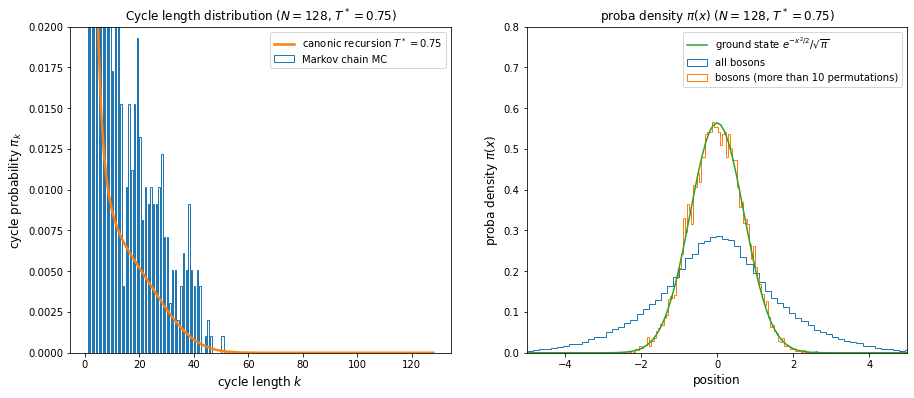

In [14]:
N = 128
T_star = 0.75
# Markov chain MC
positions, cycle_lengths, pos_long_cycle, x_all = markov_chain_MC(N=N, T_star=T_star)
plot_distributions(cycle_lengths, pos_long_cycle, x_all, N=N, T_star=T_star)

- Bosons are spread out in space at high temperature

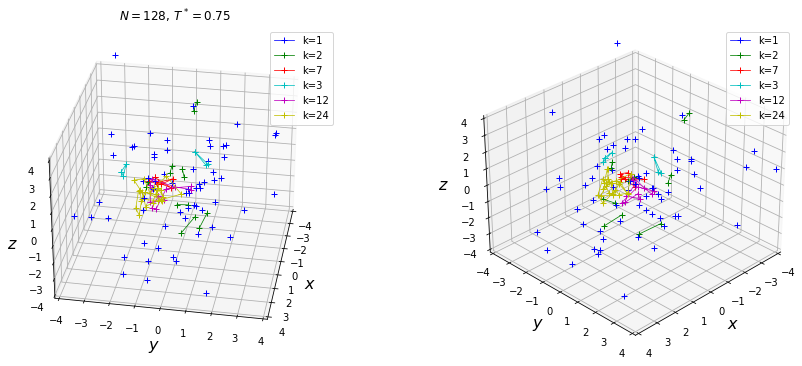

In [15]:
plot_bosons_3D(positions, N, T_star)

### Markov chain MC simulation at lower temperature

- more longer cycles (more permutations)
- particles with many permutations are in the ground state, and more particles populate the ground state

<ipython-input-8-9533412b41cb>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(nsteps)):


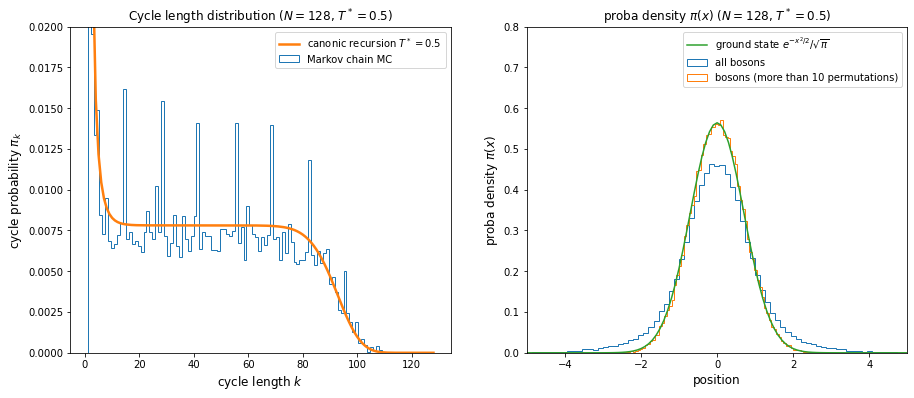

In [16]:
N = 128
T_star = 0.5
positions, cycle_lengths, pos_long_cycle, x_all = markov_chain_MC(N=N, T_star=T_star)
plot_distributions(cycle_lengths, pos_long_cycle, x_all, N=N, T_star=T_star)

- Bosons occupy a smaller region of space

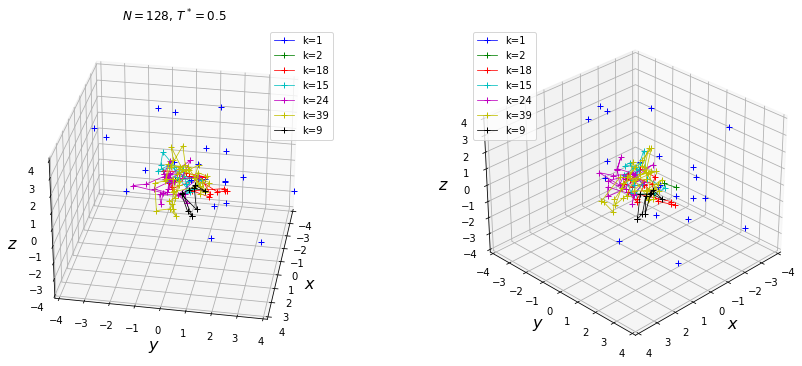

In [18]:
plot_bosons_3D(positions, N, T_star)

### Markov chain MC simulation at low temperature

- number of permutations extend further
- most particles are in the ground state

<ipython-input-8-9533412b41cb>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(nsteps)):


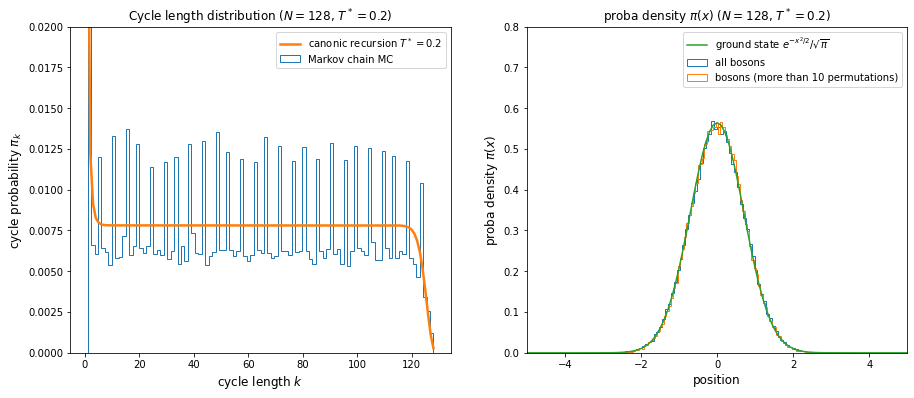

In [19]:
N = 128
T_star = 0.2
positions, cycle_lengths, pos_long_cycle, x_all = markov_chain_MC(N=N, T_star=T_star)
plot_distributions(cycle_lengths, pos_long_cycle, x_all, N=N, T_star=T_star)

- Bosons condensate in a reduced region of state
- Effect is more pronounced for bosons on longer cycles
- => **Bose-Einstein condensation**

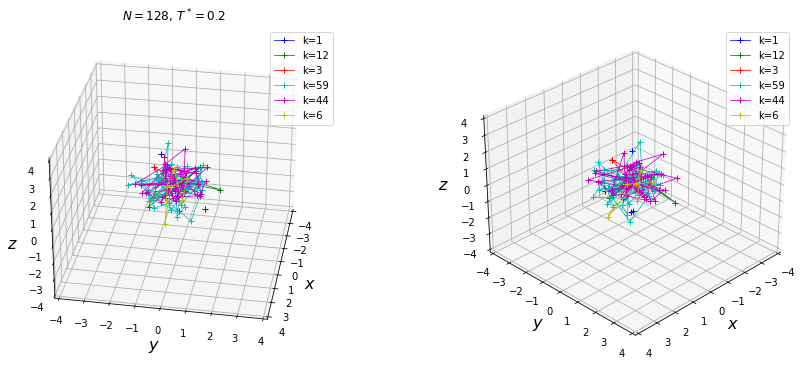

In [20]:
plot_bosons_3D(positions, N, T_star)

## Anisotropic Bose-Einstein condensate

Shaping the Bose-Einstein condensate using different oscillator strengths along x,y,z directions

### Pancake BEC

In [56]:
N=512
T_star=0.7
omega_x=1.0
omega_y=5.0
omega_z=1.0
positions, cycle_lengths, pos_long_cycle, x_all = markov_chain_MC(N=N, T_star=T_star, 
                                                                  omega_x=omega_x, omega_y=omega_y, omega_z=omega_z)


<ipython-input-36-9533412b41cb>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(nsteps)):


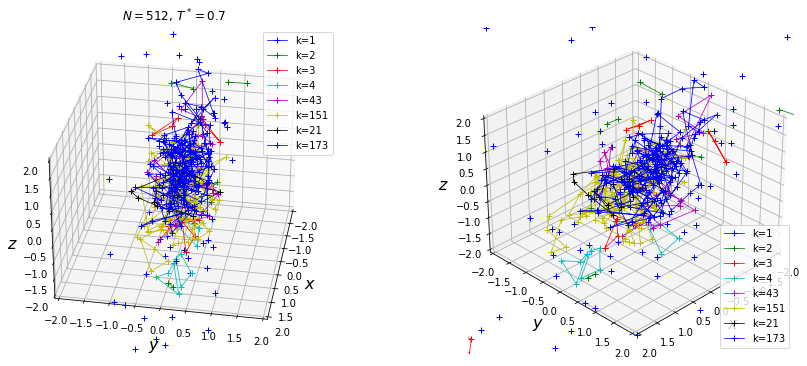

In [65]:
plot_bosons_3D(positions, N, T_star, xlim=2, ylim =2, zlim=2)

### Cigar BEC

In [37]:
N=512
T_star=0.7
omega_x=1.0
omega_y=5.0
omega_z=1.0
positions, cycle_lengths, pos_long_cycle, x_all = markov_chain_MC(N=N, T_star=T_star, 
                                                                  omega_x=omega_x, omega_y=omega_y, omega_z=omega_z)


<ipython-input-36-9533412b41cb>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(nsteps)):


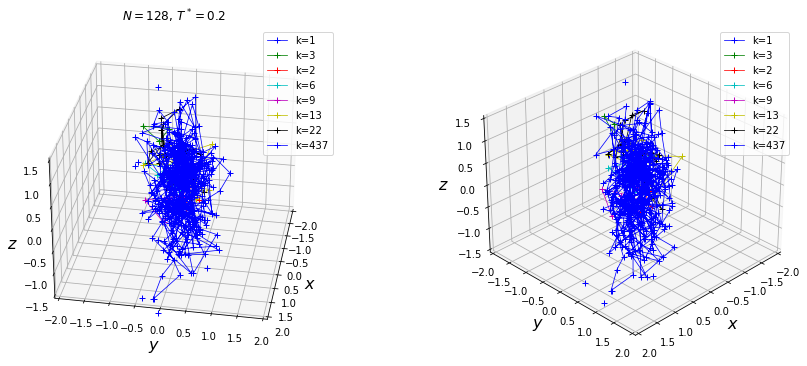

In [53]:
plot_bosons_3D(positions, N, T_star, xlim=2, ylim =2, zlim=1.5)